In [1]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding
from keras.models import Model

__articles_path = "raw_data/citeulike-a/raw-data.csv"
__tags_path = "raw_data/citeulike-a/tags.dat"
__articles_tags_path = "raw_data/citeulike-a/item-tag.dat"
__vocabulary_path = "raw_data/citeulike-a/vocabulary.dat"
__gloove_w2v_path = "raw_data/glove/glove_840B_w2v.txt"

Using TensorFlow backend.


# Project Aim:

The aim of the project is to understand how deep learning methods can be adapted in a text-based multi-label classification problem and how the developed system performs over the classical methods. 

## Dataset

The original dataset was provided by Cite-u-Like. The following files were available:

- `tags.dat`:  tags, sorted by tag-id's
- `item-tag.dat`:  tags corresponding to articles: line=article_id, values: tag associated to the article_id
- `raw-data.csv`: articles:
    - "doc.id"      : article's id (correspond to a line in the item-tag.dat file)
    - "title"       : title of the article
    - "citeulike.id": cite-u-like article's id
    - "raw.title"   : article's title
    - "raw.abstract": article's abstract

## Step 1: 

The first step of the work was the extraction of the 20 tag with higest frequency.
The variable `TOP_N_TAGS` represent the number of tags that we are going to analyze. 
To each tag was assigned an id in the range [0-TOP_N_TAG].

The following steps were performed in order to identify the TOP_N tags.

In [83]:
TOP_N_TAGS = 20

In [84]:
tags = pd.read_csv(__tags_path, header=None, names=["tag_name"])

In [85]:
tags.insert(0, "tag_id", np.arange(0, len(tags)))

In [86]:
tags.insert(2, "tag_frequency", np.zeros(len(tags), dtype=int))

In [87]:
tags.insert(3, "tag_document_list", "")

tags.head(1)

,tag_id,tag_name,tag_frequency,tag_document_list
0,0,ucsc-browser,0,


In [88]:
articles_tags = pd.read_csv(__articles_tags_path, header=None, names=["tag_list"])

articles_tags.head(1)

,tag_list
0,17 4276 32443 37837 3378 7650 44590 42810 2881...


In [89]:
# Compute the frequency of each tag and the list of document 
for idx, tag_list in articles_tags.itertuples():
    doc_id = idx + 1
    tags_for_doc = tag_list.split(" ")
    tags_for_doc = tags_for_doc[1:] # The first number indicates how many tags we have for the document.
    for tag_id in tags_for_doc:
        tag_id = int(tag_id)
        tags.at[tag_id, "tag_frequency"] += 1
        tags.at[tag_id, "tag_document_list"] += str(doc_id)+"|"

In [90]:
tags.head(2)

,tag_id,tag_name,tag_frequency,tag_document_list
0,0,ucsc-browser,2,14123|14388|
1,1,rr_interval,1,5192|


In [91]:
# Retrieve the TOP_N_TAG 

top_n_tags = tags.nlargest(TOP_N_TAGS, 'tag_frequency')

In [92]:
# Assign a new id to the extracted TOP_N_TAGS tags.

top_n_tags.insert(1, "tag_new_id", np.arange(0, TOP_N_TAGS))

In [93]:
top_n_tags.head(20)

,tag_id,tag_new_id,tag_name,tag_frequency,tag_document_list
44590,44590,0,review,1735,1|2|3|4|10|11|29|39|43|44|48|50|55|57|61|62|10...
1540,1540,1,bioinformatics,1522,4|16|37|40|42|43|48|51|58|66|99|129|130|131|20...
37837,37837,2,network,1391,1|2|3|4|5|6|7|8|9|11|12|13|14|16|18|20|23|24|2...
16833,16833,3,evolution,1373,2|9|37|44|51|95|99|117|172|209|230|246|253|270...
30698,30698,4,networks,1200,1|2|3|4|5|6|8|10|11|12|13|14|15|16|18|19|20|21...
25906,25906,5,software,1015,9|42|45|99|121|136|181|201|212|222|231|256|429...
31876,31876,6,genomics,993,9|16|21|43|48|57|58|66|205|206|462|494|498|513...
28131,28131,7,genome,805,9|27|37|51|205|206|209|270|472|622|674|686|694...
39682,39682,8,statistics,755,3|4|10|16|28|53|78|98|104|105|152|201|271|277|...
45441,45441,9,analysis,740,5|6|16|17|28|45|53|58|66|101|141|143|205|227|2...


## Step 2 

The aim of the second step is to identify and retrieve the articles that were tagged with at least one of the TOP_N_TAGS identified in the previous phase.

In this phase was also assigned an "y_true" vector to each article identified.
This vector is an array that contains 1 in the i-th position if the article was tagged with the tag that has id `i`, 0 otherwise.

<!--
> Estraggo gli articoli con i top-20 tag

> Ad ogni documento associo un vettore [0-19] in modo che alla posizione i-esima è associato uno se al documento è associato il tag con id i
  (Questa cosetta qui rappresenta l'uscita della mia rete, dato che devo fare classificazione multi-label)
-->

In [94]:
# Get the list of documents that are associated with at least one of the TOP_N_TAGS tags.

doc_ids_from_best_tags = list(map(lambda tdl: [int(d_id) for d_id in tdl.split("|") if d_id != ""], top_n_tags["tag_document_list"].tolist()))
doc_ids_from_best_tags = list(set(doc_id for doc_ids_list in doc_ids_from_best_tags for doc_id in doc_ids_list ))

In [95]:
print(len(doc_ids_from_best_tags))

8386


In [96]:
articles = pd.read_csv(__articles_path, encoding="iso-8859-15")

In [97]:
# Retrieve only the article's information for the articles identified before.

articles_top_tag = articles.loc[ articles["doc.id"].isin(doc_ids_from_best_tags) ]

articles_top_tag.head(1)

,doc.id,title,citeulike.id,raw.title,raw.abstract
0,1,the metabolic world of escherichia coli is not...,42.0,The metabolic world of Escherichia coli is not...,To elucidate the organizational and evolutiona...


In [98]:
top_n_tag_ids_list = top_n_tags["tag_id"].tolist()

top_n_tag_ids_list

[44590,
 1540,
 37837,
 16833,
 30698,
 25906,
 31876,
 28131,
 39682,
 45441,
 1934,
 34723,
 6861,
 20309,
 21404,
 29430,
 30120,
 36185,
 2061,
 38780]

In [108]:
# This function allow to create the output vector for an article:
# The function create a zero vector and places ones in the position associated to the tag ids.

def generate_article_output(article):
    article_id = article["doc.id"]
    article_output = np.zeros(TOP_N_TAGS, dtype=int)
    
    tags_for_article = articles_tags.iloc[article_id-1, 0].split(" ")
    for idx, tag_id in enumerate(tags_for_article):
        tag_id = int(tag_id)
        if idx != 0 and tag_id in top_n_tag_ids_list:
            tag_new_id = top_n_tags.loc[ top_n_tags["tag_id"] == tag_id, "tag_new_id" ].tolist()[0]
            article_output[tag_new_id] = 1
    return np.array(article_output.tolist(), dtype=int)
    

articles_top_tag.loc[:, "y_true"] = articles_top_tag.apply(generate_article_output, axis=1)

In [109]:
articles_top_tag.head()

,doc.id,title,citeulike.id,raw.title,raw.abstract,y_true
0,1,the metabolic world of escherichia coli is not...,42.0,The metabolic world of Escherichia coli is not...,To elucidate the organizational and evolutiona...,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,reverse engineering of biological complexity,43.0,Reverse Engineering of Biological Complexity,Advanced technologies and biology have extreme...,"[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,3,exploring complex networks,44.0,Exploring complex networks,"The study of networks pervades all of science,...","[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,4,comparative assessment of largescale data sets...,46.0,Comparative assessment of large-scale data set...,Comprehensive protein protein interaction maps...,"[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ..."
4,5,navigation in a small world,47.0,Navigation in a small world,The small-world phenomenon â the principle t...,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, ..."


## Step 3

this step aims to build the vocabulary of the words that will be used to represent our articles and our input

The vocabylary is saved in the structure `my_vocabulary` that has the following structure:


<!--"document_list" : [doc_id_1, ... , doc_id_k],-->
<!--"document_list" : [doc_id_1, ... , doc_id_j],-->
        
```JSON

my_vocabulary = {

    "word_1" : {
    
        "word_id": 1,
        "embedding_vector": [ ... ]
    }
    ...
    
    "word_n" : {
    
        "word_id": n,
        "embedding_vector": [ ... ]
    }
}


```
For each word:

- `word_id`: represent the unique id assigned to that word
<!-- - `document_list`: the list of documents (ids) in which the word can be found in the title -->
- `embedding_vector`: a word2vector representation of the word

The dictionary `id_to_word` allows to map the reference `word_id -> word` and therefore to access, given an id, to the word in a simple and fast way.

The vocabulary is built by applying the custom functions `stopwords_removal_and_tokenization` and `create_vocabulary` on each `raw.title` of the selected articles:

- The function `stopwords_removal_and_tokenization` tokenize the sentences of the title, remove al the stop words, all the punctuation and update the property `new_title` with the filtered words.

- The function `create_vocabulary`, using all the words in the `new_title` property created with the previous function, updates the vocabulary.

- The function `get_articles_words_ids` generates a column `new_title_words_id` for each article. This column contains the list of the word's ids filtered in the `new_title` property.


The `pad_title` function allows to memorize in the `new_title_words_id_padded` column the input that will be supplied to the network. The function, from the `new_title_words_id` property, allows to generate a zero vector of length `MAX_TITLE_LEN` (the length of the longest title), in which the non-zero elements are the id of the words present in the title.

In [110]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation    

stop_words = set(stopwords.words('english'))  # load stop words list

In [111]:
my_vocabulary = {} # word -> {word_id: xxxx, word_documents: [doc1, doc2, ... docN], embedding_vector: [] }
id_to_word = {} # word_id -> word

In [112]:
def stopwords_removal_and_tokenization(text):
    words_filtered = []
    for sent in sent_tokenize(text):
        title_tokenized = word_tokenize(sent)
        for i, w in enumerate(title_tokenized):
            if i == 0:  # Heuristic: the case of the first word after a period can be stripped
                w = w.lower()
            if i != 0 and title_tokenized[i-1] in punctuation:
                w = w.lower()
            if w not in stop_words and len(w) > 2 and ((w not in punctuation) or (w in punctuation and w.find("-") != -1)):
                words_filtered.append(w)
    
    return " ".join(words_filtered)


def create_vocabulary(text, vocabulary, id_word_map):
    words_filtered = text.split(" ")
    for w in words_filtered:
        if w not in vocabulary:
            next_word_id = 1 if (len(id_word_map.keys()) == 0) else max(id_word_map.keys()) + 1
            id_word_map[next_word_id] = w
            vocabulary[w] = {"word_id": next_word_id, "word_documents": []}

def get_article_words_ids(text, vocabulary):
    return [vocabulary[w]["word_id"] for w in text.split(" ")]

In [113]:
articles_top_tag.loc[:, 'new_title' ] = articles_top_tag.loc[:, "raw.title"].apply(stopwords_removal_and_tokenization)

articles_top_tag.loc[:, "new_title"].apply(create_vocabulary, args=(my_vocabulary, id_to_word,))

articles_top_tag.loc[:, 'new_title_words_id'] = articles_top_tag.loc[:, "new_title"].apply(get_article_words_ids, args=(my_vocabulary, ))

In [114]:
articles_top_tag.head(2)

,doc.id,title,citeulike.id,raw.title,raw.abstract,y_true,new_title,new_title_words_id
0,1,the metabolic world of escherichia coli is not...,42.0,The metabolic world of Escherichia coli is not...,To elucidate the organizational and evolutiona...,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",metabolic world Escherichia coli small,"[1, 2, 3, 4, 5]"
1,2,reverse engineering of biological complexity,43.0,Reverse Engineering of Biological Complexity,Advanced technologies and biology have extreme...,"[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",reverse Engineering Biological Complexity,"[6, 7, 8, 9]"


In [115]:
# Padding sentences
MAX_TITLE_LEN = len(max(articles_top_tag["new_title_words_id"].tolist(), key=len))

In [116]:
MAX_TITLE_LEN

18

In [117]:
def pad_title(words_id, maxlen):
    padded_title = pad_sequences([words_id], maxlen=maxlen)
    return padded_title[0]

articles_top_tag.loc[:, "new_title_words_id_padded" ] = articles_top_tag.loc[:, "new_title_words_id"].apply(pad_title, args=(MAX_TITLE_LEN,))

In [118]:
articles_top_tag.loc[0, "new_title_words_id_padded"]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5], dtype=int32)

## Step 5: 

In this step is developed a simple model with the sklearn pipeline object.
The model has as first component a TFIDFVectorizer object that, given an input of text, compute the tf-idf matrix.
The second component is simply a LogisticRegression classifier embedded in an OneVsRestClassifier.
This is necessary in order to create a multi-label classifier.

```

reference_model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'))),
]);

```

In [119]:
import matplotlib.pyplot as plt

def plot_barchart(labels, data, title="", colors=None):
    
    if colors is None:
        colors = ["#1f77b4"] * len(labels)
    
    indexes = np.arange(len(labels))
    plt.bar(indexes, data, color=colors)
    plt.xticks(indexes, labels, fontsize=10, rotation=30)
    plt.title(title)
    plt.show()
    
# data = list( {y:list(points), x:list(points), c:"color", label: "some label" } )
def plot_linechart(data, title=""):
    for d in data:
        plt.plot(d["x"], d["y"], d["c"], label=d["l"])
    plt.title(title)
    plt.legend()
    # plt.figure()
    plt.show()

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

In [121]:
train_set, test_set = train_test_split(articles_top_tag, test_size=0.1, shuffle=True, random_state=1993)

In [122]:
reference_model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'))),
]);

In [123]:
# Train set input and y_true for the first model
reference_model_train_set_input = np.array(train_set["new_title"].tolist())
reference_model_train_set_y_true = np.array(train_set["y_true"].tolist())

# Test set input and y_true for the first model
reference_model_test_set_input = np.array(test_set["new_title"].tolist())
reference_model_test_set_y_true = np.array(test_set["y_true"].tolist())

print(reference_model_train_set_input.shape, reference_model_train_set_y_true.shape, reference_model_test_set_input.shape, reference_model_test_set_y_true.shape)

((7547,), (7547, 20), (839,), (839, 20))


In [124]:
reference_model.fit(reference_model_train_set_input, reference_model_train_set_y_true)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=Tru..._state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))])

In [125]:
reference_model_test_set_y_pred = reference_model.predict(reference_model_test_set_input)
    
reference_model_test_set_precision, reference_model_test_set_recall, reference_model_test_set_f1, reference_model_test_set_support = precision_recall_fscore_support(reference_model_test_set_y_true, reference_model_test_set_y_pred, average="micro")
    
print(reference_model_test_set_precision, reference_model_test_set_recall, reference_model_test_set_f1)

(0.754601226993865, 0.27547592385218367, 0.4036095159967186)


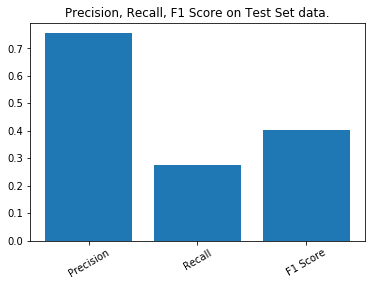

In [126]:
labels = ["Precision", "Recall", "F1 Score"]
data = [reference_model_test_set_precision, reference_model_test_set_recall, reference_model_test_set_f1]
title = "Precision, Recall, F1 Score on Test Set data."

plot_barchart(labels, data, title)    

## Step 6

In this step the embedding matrix is built.

In order to maximize the number of words with a word2vec representation the pre-trained model used is the one provided by [GloVe](https://nlp.stanford.edu/projects/glove/) with 840B tokens, 2.2M cased words.

The generated matrix assign a zero-vector to each word that is not found in the glove dictionary.

In this phase the property `embedding_vector` of the structure `my_vocabulary` is updated.

In [127]:
VECTOR_DIMENSION = 300

In [128]:
word2vec = KeyedVectors.load_word2vec_format(__gloove_w2v_path)

In [129]:
def build_embedding_matrix(vocabulary, w2v_model, vector_dimension):
    
    e_m = np.zeros((len(vocabulary)+1, vector_dimension))

    # fill this matrix with values from pre-trained word2vec
    for word in vocabulary:
        word_id = vocabulary[word]["word_id"]
        if word in w2v_model.vocab:
            e_m[word_id] = w2v_model.word_vec(word)
    
        vocabulary[word]["embedding_vector"] = e_m[word_id]
    
    return e_m

def get_words_without_w2v(vocabulary):
    return [ w for w in vocabulary if(np.count_nonzero(vocabulary[w]["embedding_vector"]) == 0)]

def print_vocabulary_stats(vocabulary):
    words_not_found = get_words_without_w2v(vocabulary)
    print(len(vocabulary), len(words_not_found), len(words_not_found)/float(len(vocabulary)))

In [130]:
embedding_matrix = build_embedding_matrix(my_vocabulary, word2vec, VECTOR_DIMENSION)

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.59028   ,  0.67391002, -0.49757001, ..., -0.38861999,
        -0.49307001, -0.31288999],
       [-0.0066796 ,  0.22238   ,  0.27709001, ...,  0.059372  ,
         0.0014085 ,  0.098727  ],
       ...,
       [-0.80913001,  0.0085352 , -0.10499   , ..., -0.42377999,
        -0.29381001, -0.019974  ],
       [-0.15756001, -0.12185   , -0.043436  , ..., -0.0081011 ,
        -0.0024309 , -0.039019  ],
       [-0.94972003,  0.69369   , -0.14569999, ..., -0.84353   ,
         0.015453  , -0.042529  ]])

In [131]:
print_vocabulary_stats(my_vocabulary)

(11638, 1363, 0.11711634301426362)


## Step 6

In this step the articles are splitted in test set and training set and the first model was built.

### First Model

The model developed with Keras is the following:

```
Layer (type)        Output Shape       
=======================================
InputLayer          (0, 24)            
_______________________________________
EmbeddingLayer      (0, 24, 300)       
_______________________________________
LSTM                (0, 300)              
_______________________________________
OutputLayer         (0, 20)                  
=======================================
```

#### Evaluation Metrics

During the training the `EarlyStoppingCriteria` was used in order to speed-up the process.
The `EarlyStopByF1` class implementing the `keras.callbacks.Callback` interface is responsible to stop the training once that the F1-Score does not change at least of `0.05` between one epoch and the next one.
The model save the weights every time that a new best F1-Score is achieved.
This class is also responsible to evaluate the following metrics:

- Micro-Average Precision
- Micro-Average Recall
- Micro-Average F1 Measure

In the Micro-average method, we are going to sum up all the individual true positives, false positives, and false negatives for different sets and the apply them to get the statistics. 

For example if:

- y_true = [ [0, 0, 1, 1], [0, 0, 1, 1], [0, 0, 1, 1] ]


- y_true = [ [1, 0, 1, 1], [1, 1, 1, 1], [0, 0, 0, 1] ]


- kind = [ [FP, TN, TP, TP], [FP, FP, TP, TP], [TN, TN, FN, TP] ]
 

then we have that: 

- Test1 : 
    - TP1 = 2
    - FP1 = 1
    - FN1 = 0
    
    
- Test2 : 
    - TP2 = 2
    - FP2 = 2
    - FN2 = 0
    
    
- Test3 : 
    - TP3 = 1
    - FP3 = 0
    - FN3 = 1

therefore:

- Micro-Average Precision: (TP1 + TP2 + TP3) / (TP1 + FP1 + TP2 + FP2 + TP3 + FP3) = 5/7

- Micro-Average Recall: (TP1 + TP2 + TP3) / (TP1 + FN1 + TP2 + FN2 + TP3 + FN3)  = 5/6

- Micro-Average F1-Measure: (1 + b^2) * (MP * MR)/( (b^2 * MP) + MR )


In the macro-average method, instead, the average of the precision and recall on different sets are taken. 
For the previous example, this mean that

- Test1 : 
    - P1 = TP1 / (TP1 + FP1) = 2/3
    - R1 = TP1 / (TP1 + FN1) = 2/2
    
- Test2 : 
    - P2 = TP2 / (TP2 + FP2) = 2/4
    - R2 = TP2 / (TP2 + FN2) = 2/2
    
- Test3 : 
    - P3 = TP3 / (TP3 + FP3) = 1/1
    - R3 = TP3 / (TP3 + FN3) = 1/2

therefore:

- Macro-Average Precision (MAP) = (P1 + P2 + P3) / 3 

- Macro-Average Recall (MAR) = (R1 + R2 + R3) / 3 

- Macro-Average F1-Measure : harmonic mean of MAP and MAR .


#### Layers

##### First Layer

The first layer is the layer of input. This layer accept as input a vector of length 24, the length of the longest title. The input vector, as described before, has in every position the id of the word present in that sentence.
For istance, if the title of an article is `The metabolic world of Escherichia coli is not small` and after the pre-processing phase the result title is `metabolic world Escherichia coli small` or, in terms of word's ids `[1, 2, 3, 4, 5]`, then the input vector is the following `[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5]`.

##### Embedding Layer

The second layer is the Embedding Layer and has a shape of `(0, 24, 300)`. Each word in the title is represented with a 300 dimensional vector, so each word is mapped to the respective word2vec vector.
The embedding matrix is used in order to assign a weight to each vector and is not update during the training process.

##### LSTM Layer

The third layer is the LSTM layer that is the layer in which our network model should be able to learn the dependencies between each word in the title.

<!--##### Hidden Layers
The hidden layers used are 2. Both of them use `ReLu` as activation function.-->

##### Output Layer
The output Layer has a dimension of TOP_N_TAGS, 20 in this example.
Each output neuron store a value between [0, 1] thanks to the `Sigmoid` function that is used as activation function.


In [132]:
first_model_train_set_input =  np.array(train_set.loc[:, "new_title_words_id_padded"].tolist())

first_model_train_set_input.shape

(7547, 18)

In [133]:
first_model_train_set_y_true = np.array(train_set.loc[:, "y_true"].tolist())

first_model_train_set_y_true.shape

(7547, 20)

In [134]:
first_model_test_set_input = np.array(test_set.loc[:, "new_title_words_id_padded"].tolist())

first_model_test_set_input.shape

(839, 18)

In [135]:
first_model_test_set_y_true = np.array(test_set.loc[:, "y_true"].tolist())

first_model_test_set_y_true.shape

(839, 20)

In [136]:
OUTPUT_ACTIVATION_THRESHOLD = 0.5
F1_PATIENCE = 0.03
F1_BETA = 1.0

In [137]:
def get_output(output_array, threshold=0.5):
    if threshold == 0.5:
        return np.around(output_array).astype(int)
    return np.array( [1 if x > threshold else 0 for x in output_array] , dtype=int)

In [138]:
import keras.callbacks as keras_callbacks 

class EarlyStopByF1(keras_callbacks.Callback):
    
    def __init__(self, output_activation_threshold=0.5, f1_score_patience=0.03, f1_score_beta=1.0, save_to_path="weights.hdf5"):
        super(keras_callbacks.Callback, self).__init__()
        self.output_activation_threshold = output_activation_threshold
        self.f1_score_patience = f1_score_patience
        self.f1_score_beta = f1_score_beta
        self.save_to_path = save_to_path
        
    def on_train_begin(self, logs={}):
        self.f1s = []
        self.recalls = []
        self.precisions = []
        
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

        self.best_f1_score = 0

        
    def on_epoch_end(self, epoch, logs={}):
                
        val_x = self.validation_data[0]
        val_y = self.validation_data[1]
        
        val_y1 = get_output(self.model.predict(val_x), self.output_activation_threshold)
        
        step_val_precision, step_val_recall, step_val_f1, step_support = precision_recall_fscore_support(val_y, val_y1, beta=self.f1_score_beta, average="micro")
        
        if step_val_f1 > self.best_f1_score:
            self.best_f1_score = step_val_f1
            self.model.save_weights(self.save_to_path)
        elif self.best_f1_score - step_val_f1 > self.f1_score_patience:
                print("Epoch %d: early stopping by F1" % epoch)
                self.model.stop_training = True
       
        self.val_f1s.append(step_val_f1)
        self.val_recalls.append(step_val_recall)
        self.val_precisions.append(step_val_precision)
        print("val_f1: %f — val_precision: %f — val_recall %f" %(step_val_f1, step_val_precision, step_val_recall) )
        return

In [139]:
def get_model(vocabulary, sentence_length, vector_dimension, output_length, embedding_matrix):
    vocabulary_size = len(vocabulary)+1
    
    # https://keras.io/layers/embeddings/
    embedding_layer = Embedding(
        vocabulary_size, # how many words are mapped into vectors
        vector_dimension, # size of output vector dimension
        input_length=sentence_length, # how many words in the sentence we process
        weights=[embedding_matrix], # weights initialized from the pre-trained model
        trainable=False) # we will not update this layer

    lstm_layer = LSTM(vector_dimension) # number of outputs
    
    sentence_input = Input(shape=(sentence_length,), dtype="int32") # the input takes
    embedded_sentence = embedding_layer(sentence_input)
    lstm_layer = lstm_layer(embedded_sentence)
    
    # deep layers
    #deep_layer1_dim = 150
    #deep_layer1 = Dense(deep_layer1_dim, activation="relu")(lstm_layer)

    #deep_layer2_dim = 50
    #deep_layer2 = Dense(deep_layer2_dim, activation="relu")(deep_layer1)

    prediction = Dense(output_length, activation="sigmoid")(lstm_layer)
    model = Model(inputs=[sentence_input], outputs=prediction)
    
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [140]:
first_model = get_model(my_vocabulary, MAX_TITLE_LEN, VECTOR_DIMENSION, TOP_N_TAGS, embedding_matrix)

first_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 18)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 18, 300)           3491700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                6020      
Total params: 4,218,920
Trainable params: 727,220
Non-trainable params: 3,491,700
_________________________________________________________________


In [141]:
first_model_weights_path = "first_model_weights.hdf5"

first_model_early_stop_by_f1 = EarlyStopByF1(OUTPUT_ACTIVATION_THRESHOLD, F1_PATIENCE, F1_BETA, first_model_weights_path)
first_model_early_stop_by_val_acc = keras_callbacks.EarlyStopping(monitor='val_loss', patience=3)

first_model_metrics = [first_model_early_stop_by_f1] #, first_model_early_stop_by_val_acc]

In [142]:
first_model_history = first_model.fit(first_model_train_set_input, first_model_train_set_y_true, validation_split=0.1, batch_size=128, epochs=50, callbacks=first_model_metrics)

Train on 6792 samples, validate on 755 samples
Epoch 1/50
6792/6792 [==============================] - 12s 2ms/step - loss: 0.3387 - acc: 0.8801 - val_loss: 0.2723 - val_acc: 0.8986
val_f1: 0.210418 — val_precision: 0.576271 — val_recall 0.128707
Epoch 2/50
6792/6792 [==============================] - 9s 1ms/step - loss: 0.2527 - acc: 0.9037 - val_loss: 0.2409 - val_acc: 0.9107
val_f1: 0.382784 — val_precision: 0.697830 — val_recall 0.263722
Epoch 3/50
6792/6792 [==============================] - 9s 1ms/step - loss: 0.2348 - acc: 0.9108 - val_loss: 0.2360 - val_acc: 0.9115
val_f1: 0.418443 — val_precision: 0.673669 — val_recall 0.303470
Epoch 4/50
6792/6792 [==============================] - 9s 1ms/step - loss: 0.2254 - acc: 0.9149 - val_loss: 0.2296 - val_acc: 0.9134
val_f1: 0.435421 — val_precision: 0.690411 — val_recall 0.317981
Epoch 5/50
6792/6792 [==============================] - 10s 1ms/step - loss: 0.2154 - acc: 0.9179 - val_loss: 0.2265 - val_acc: 0.9164
val_f1: 0.466413 — va

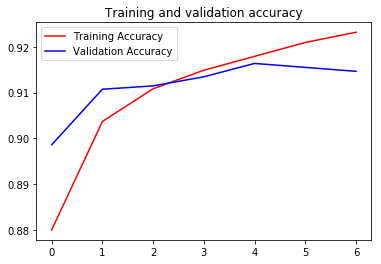

In [143]:
first_model_acc = first_model_history.history['acc']
first_model_val_acc = first_model_history.history['val_acc']
first_model_epochs = range(len(first_model_acc))
 
data = [
    {"x": first_model_epochs, "y": first_model_acc, "c":"r", "l": "Training Accuracy"},
    {"x": first_model_epochs, "y": first_model_val_acc, "c":"b", "l": "Validation Accuracy"}
]

title = "Training and validation accuracy"

plot_linechart(data, title)

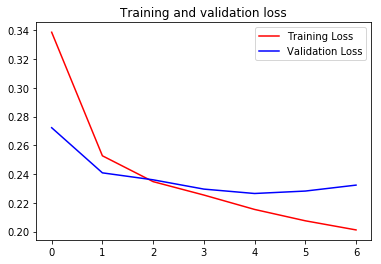

In [144]:
first_model_loss = first_model_history.history['loss']
first_model_val_loss = first_model_history.history['val_loss']

data = [
    {"x": first_model_epochs, "y": first_model_loss, "c":"r", "l": "Training Loss"},
    {"x": first_model_epochs, "y": first_model_val_loss, "c":"b", "l": "Validation Loss"}
]

title = "Training and validation loss"

plot_linechart(data, title)

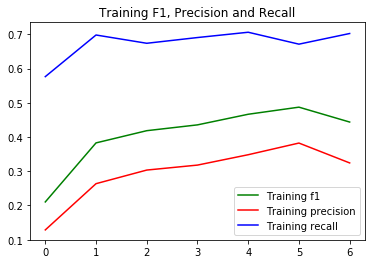

In [145]:
first_model_val_f1 = first_model_early_stop_by_f1.val_f1s
first_model_val_precision = first_model_early_stop_by_f1.val_precisions
first_model_val_recall = first_model_early_stop_by_f1.val_recalls

data = [
    {"x": first_model_epochs, "y": first_model_val_f1, "c":"g", "l": "Training f1"},
    {"x": first_model_epochs, "y": first_model_val_recall, "c":"r", "l": "Training precision"},
    {"x": first_model_epochs, "y": first_model_val_precision, "c":"b", "l": "Training recall"},
]

title = "Training F1, Precision and Recall"

plot_linechart(data, title)

In [146]:
# Load best weights and recompile the model
first_model.load_weights(first_model_weights_path)

first_model_test_set_y_pred = get_output(first_model.predict(first_model_test_set_input), OUTPUT_ACTIVATION_THRESHOLD)

first_model_test_set_precision, first_model_test_set_recall, first_model_test_set_f1, first_model_test_set_support = precision_recall_fscore_support(first_model_test_set_y_true, first_model_test_set_y_pred, average="micro")

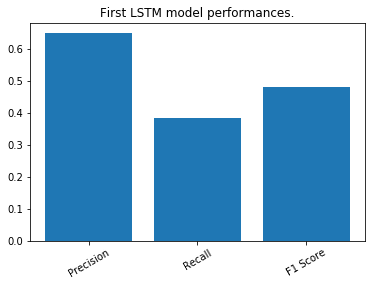

In [147]:
labels = ["Precision", "Recall", "F1 Score"]
data = [first_model_test_set_precision, first_model_test_set_recall, first_model_test_set_f1]
title = "First LSTM model performances."

plot_barchart(labels, data, title)

# Step 7: Comparison and Further Analysis

In this section the 2 models are evaluated based on the metrics defined in the section 2.

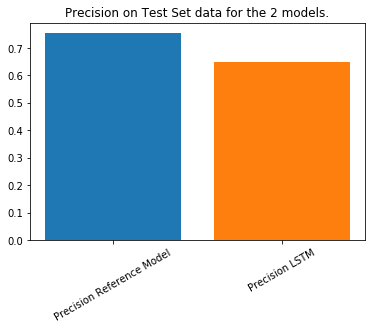

In [148]:
# Compare Precision 

FIRST_MODEL_COLOR = "#ff7f0e"
REFERENCE_MODEL_COLOR = "#1f77b4"

colors = [REFERENCE_MODEL_COLOR, FIRST_MODEL_COLOR]

labels = ["Precision Reference Model", "Precision LSTM"]
title = "Precision on Test Set data for the 2 models."
data = [reference_model_test_set_precision, first_model_test_set_precision]

plot_barchart(labels, data, title, colors=colors)

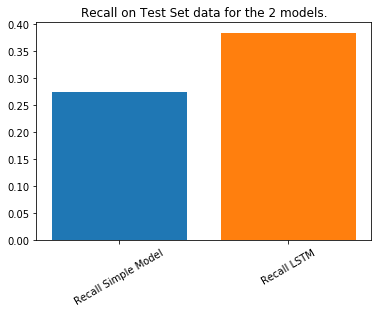

In [149]:
# Compare Recall 

labels = ["Recall Simple Model", "Recall LSTM"]
data =  [reference_model_test_set_recall, first_model_test_set_recall]
title = "Recall on Test Set data for the 2 models."

plot_barchart(labels, data, title, colors=colors)

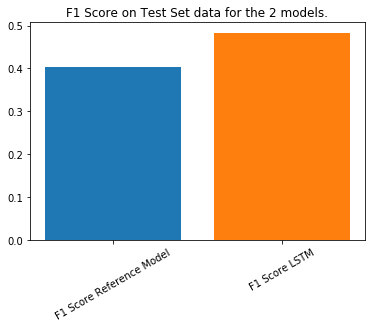

In [150]:
# Compare F1

labels = ["F1 Score Reference Model", "F1 Score LSTM"]
data = [reference_model_test_set_f1, first_model_test_set_f1]
title = "F1 Score on Test Set data for the 2 models."

plot_barchart(labels, data, title, colors=colors)

## Step 7.1: Better representation of the input

In this step i try to understand if the devolped models can give us better performance when the vocabulary is built on top of the `raw.abstract` property of the articles. 

In [151]:
my_vocabulary_abstract = {} # word -> {word_id: xxxx, word_documents: [doc1, doc2, ... docN], embedding_vector: [] }
id_to_word_abstract = {} # word_id -> word

In [152]:
articles_top_tag.loc[:, 'new_abstract' ] = articles_top_tag.loc[:, "raw.abstract"].apply(stopwords_removal_and_tokenization)

articles_top_tag.loc[:, "new_abstract"].apply(create_vocabulary, args=(my_vocabulary_abstract, id_to_word_abstract,))

articles_top_tag.loc[:, 'new_abstract_words_id'] = articles_top_tag.loc[:, "new_abstract"].apply(get_article_words_ids, args=(my_vocabulary_abstract,))

In [153]:
articles_top_tag.head(2)

,doc.id,title,citeulike.id,raw.title,raw.abstract,y_true,new_title,new_title_words_id,new_title_words_id_padded,new_abstract,new_abstract_words_id
0,1,the metabolic world of escherichia coli is not...,42.0,The metabolic world of Escherichia coli is not...,To elucidate the organizational and evolutiona...,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",metabolic world Escherichia coli small,"[1, 2, 3, 4, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...",elucidate organizational evolutionary principl...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,2,reverse engineering of biological complexity,43.0,Reverse Engineering of Biological Complexity,Advanced technologies and biology have extreme...,"[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",reverse Engineering Biological Complexity,"[6, 7, 8, 9]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, ...",advanced technologies biology extremely differ...,"[91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101,..."


In [154]:
embedding_matrix_2 = build_embedding_matrix(my_vocabulary_abstract, word2vec, VECTOR_DIMENSION)

In [155]:
print_vocabulary_stats(my_vocabulary_abstract)

(61368, 20994, 0.34210011732499024)


In [156]:
MAX_ABSTRACT_LEN = len(max(articles_top_tag["new_abstract_words_id"].tolist(), key=len))

In [157]:
MIN_ABSTRACT_LEN = len(min(articles_top_tag["new_abstract_words_id"].tolist(), key=len))

In [158]:
AVG_ABSTRACT_LEN = [len(x) for x in articles_top_tag["new_abstract_words_id"].tolist()]

In [159]:
AVG_ABSTRACT_LEN = sum(AVG_ABSTRACT_LEN) / len(AVG_ABSTRACT_LEN)

In [160]:
print(MIN_ABSTRACT_LEN, MAX_ABSTRACT_LEN, AVG_ABSTRACT_LEN)

(33, 5234, 110)


In [161]:
MAX_SENTENCE_LEN = 100

In [162]:
articles_top_tag.loc[:, "new_abstract_words_id_padded" ] = articles_top_tag.loc[:, "new_abstract_words_id"].apply(pad_title, args=(MAX_SENTENCE_LEN,))

In [163]:
train_set, test_set = train_test_split(articles_top_tag, test_size=0.1, shuffle=True, random_state=1993)

In [164]:
# Second model train set input and y_true
second_model_train_set_input =  np.array(train_set.loc[:, "new_abstract_words_id_padded"].tolist())
second_model_train_set_y_true = np.array(train_set.loc[:, "y_true"].tolist())

# Second model test set input and y_true
second_model_test_set_input = np.array(test_set.loc[:, "new_abstract_words_id_padded"].tolist())
second_model_test_set_y_true = np.array(test_set.loc[:, "y_true"].tolist())

In [165]:
second_model = get_model(my_vocabulary_abstract, MAX_SENTENCE_LEN, VECTOR_DIMENSION, TOP_N_TAGS, embedding_matrix_2)

second_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          18410700  
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                6020      
Total params: 19,137,920
Trainable params: 727,220
Non-trainable params: 18,410,700
_________________________________________________________________


In [166]:
second_model_weights_path = "second_model_weights.hdf5"
second_model_early_stop_by_f1 = EarlyStopByF1(OUTPUT_ACTIVATION_THRESHOLD, F1_PATIENCE, F1_BETA, second_model_weights_path)

second_model_metrics = [second_model_early_stop_by_f1]

In [167]:
second_model_history = second_model.fit(second_model_train_set_input, second_model_train_set_y_true, validation_split=0.1, batch_size=128, epochs=50, callbacks=second_model_metrics)

Train on 6792 samples, validate on 755 samples
Epoch 1/50
6792/6792 [==============================] - 44s 6ms/step - loss: 0.3442 - acc: 0.8827 - val_loss: 0.3091 - val_acc: 0.8956
val_f1: 0.033109 — val_precision: 0.586957 — val_recall 0.017035
Epoch 2/50
6792/6792 [==============================] - 45s 7ms/step - loss: 0.2939 - acc: 0.8937 - val_loss: 0.2795 - val_acc: 0.8985
val_f1: 0.152655 — val_precision: 0.618834 — val_recall 0.087066
Epoch 3/50
6792/6792 [==============================] - 46s 7ms/step - loss: 0.2704 - acc: 0.8970 - val_loss: 0.2604 - val_acc: 0.9044
val_f1: 0.272315 — val_precision: 0.678392 — val_recall 0.170347
Epoch 4/50
6792/6792 [==============================] - 47s 7ms/step - loss: 0.2518 - acc: 0.9025 - val_loss: 0.2476 - val_acc: 0.9062
val_f1: 0.307918 — val_precision: 0.683297 — val_recall 0.198738
Epoch 5/50
6792/6792 [==============================] - 49s 7ms/step - loss: 0.2375 - acc: 0.9074 - val_loss: 0.2423 - val_acc: 0.9108
val_f1: 0.419647 —

In [168]:
# Reload best weights for the model
second_model.load_weights(second_model_weights_path)

In [169]:
second_model_test_set_y_pred = get_output(second_model.predict(second_model_test_set_input), OUTPUT_ACTIVATION_THRESHOLD)

second_model_test_set_precision, second_model_test_set_recall, second_model_test_set_f1, support = precision_recall_fscore_support(second_model_test_set_y_true, second_model_test_set_y_pred, average="micro")

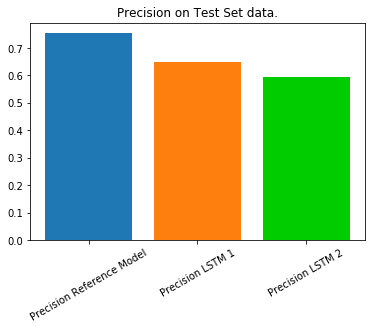

In [170]:
SECOND_MODEL_COLOR = "#00cc00"

colors = [REFERENCE_MODEL_COLOR, FIRST_MODEL_COLOR, SECOND_MODEL_COLOR]

labels = ["Precision Reference Model", "Precision LSTM 1", "Precision LSTM 2"]
data = [reference_model_test_set_precision, first_model_test_set_precision, second_model_test_set_precision]
title = "Precision on Test Set data."

plot_barchart(labels, data, title, colors=colors)

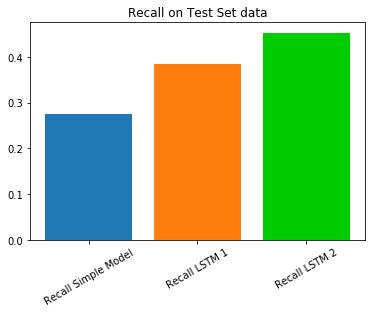

In [171]:
labels = ["Recall Simple Model", "Recall LSTM 1", "Recall LSTM 2"]
data = [reference_model_test_set_recall, first_model_test_set_recall, second_model_test_set_recall]
title = "Recall on Test Set data"

plot_barchart(labels, data, title, colors=colors)

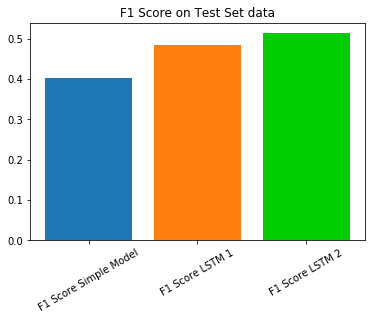

In [172]:
labels = ["F1 Score Simple Model", "F1 Score LSTM 1", "F1 Score LSTM 2"]
data = [reference_model_test_set_f1, first_model_test_set_f1, second_model_test_set_f1]
title = "F1 Score on Test Set data"

plot_barchart(labels, data, title, colors=colors)

## Step 7.2: Learning W2V

In this section we're going to understand if the model can perform better if the embeddings are learned from the set of documents.

In [173]:
articles.head(2)

,doc.id,title,citeulike.id,raw.title,raw.abstract
0,1,the metabolic world of escherichia coli is not...,42.0,The metabolic world of Escherichia coli is not...,To elucidate the organizational and evolutiona...
1,2,reverse engineering of biological complexity,43.0,Reverse Engineering of Biological Complexity,Advanced technologies and biology have extreme...


In [174]:
texts = [x.split(" ") for x in train_set.loc[:, "new_abstract"].tolist()]
texts += [x.split(" ") for x in test_set.loc[:, "new_abstract"].tolist()]

[[u'genome-scale',
  u'metabolic',
  u'network',
  u'models',
  u'reconstructed',
  u'well-characterized',
  u'organisms',
  u'using',
  u'genomic',
  u'annotation',
  u'literature',
  u'information',
  u'however',
  u'many',
  u'instances',
  u'model',
  u'predictions',
  u'metabolic',
  u'fluxes',
  u'entirely',
  u'consistent',
  u'experimental',
  u'data',
  u'indicating',
  u'reactions',
  u'model',
  u'match',
  u'active',
  u'reactions',
  u'vivo',
  u'system',
  u'introduce',
  u'method',
  u'determining',
  u'active',
  u'reactions',
  u'genome-scale',
  u'metabolic',
  u'network',
  u'based',
  u'limited',
  u'number',
  u'experimentally',
  u'measured',
  u'fluxes',
  u'method',
  u'called',
  u'optimal',
  u'metabolic',
  u'network',
  u'identification',
  u'omni',
  u'allows',
  u'efficient',
  u'identification',
  u'set',
  u'reactions',
  u'results',
  u'best',
  u'agreement',
  u'silico',
  u'predicted',
  u'experimentally',
  u'measured',
  u'flux',
  u'distributions',

In [175]:
import gensim

gensim_model = gensim.models.Word2Vec(texts, size=VECTOR_DIMENSION, window=5, min_count=1, workers=15)

gensim_model.train(texts, total_examples=len(texts), epochs=10)

(9146791, 9258320)

In [176]:
gensim_model.wv.most_similar(positive=["technologies"])

[(u'technology', 0.8721256256103516),
 (u'next-generation', 0.729889452457428),
 (u'instruments', 0.7022272944450378),
 (u'opportunities', 0.6814679503440857),
 (u'heralding', 0.6771247982978821),
 (u'ultra-high-throughput', 0.674340009689331),
 (u'small-', 0.6694091558456421),
 (u'target-enrichment', 0.6635870933532715),
 (u'era', 0.6598039865493774),
 (u'breakthroughs', 0.6573987007141113)]

In [177]:
embedding_matrix_3 = build_embedding_matrix(my_vocabulary_abstract, gensim_model.wv, VECTOR_DIMENSION)

print_vocabulary_stats(my_vocabulary_abstract)

(61368, 0, 0.0)


In [178]:
articles_top_tag.head(1)

,doc.id,title,citeulike.id,raw.title,raw.abstract,y_true,new_title,new_title_words_id,new_title_words_id_padded,new_abstract,new_abstract_words_id,new_abstract_words_id_padded
0,1,the metabolic world of escherichia coli is not...,42.0,The metabolic world of Escherichia coli is not...,To elucidate the organizational and evolutiona...,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",metabolic world Escherichia coli small,"[1, 2, 3, 4, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...",elucidate organizational evolutionary principl...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [179]:
third_model = get_model(my_vocabulary_abstract, MAX_SENTENCE_LEN, VECTOR_DIMENSION, TOP_N_TAGS, embedding_matrix_3)

In [180]:
third_model_weights_path = "third_model_weights.hdf5"
third_model_early_stop_by_f1 = EarlyStopByF1(OUTPUT_ACTIVATION_THRESHOLD, F1_PATIENCE, F1_BETA, third_model_weights_path)

third_model_metrics = [third_model_early_stop_by_f1]

In [181]:
# in this network model the input are the same for the previous model...
third_model_history = third_model.fit(second_model_train_set_input, second_model_train_set_y_true, validation_split=0.1, batch_size=128, epochs=50, callbacks=third_model_metrics)

Train on 6792 samples, validate on 755 samples
Epoch 1/50
6792/6792 [==============================] - 49s 7ms/step - loss: 0.3222 - acc: 0.8821 - val_loss: 0.2773 - val_acc: 0.8987
val_f1: 0.156646 — val_precision: 0.622807 — val_recall 0.089590
Epoch 2/50
6792/6792 [==============================] - 45s 7ms/step - loss: 0.2664 - acc: 0.8994 - val_loss: 0.2503 - val_acc: 0.9063
val_f1: 0.309419 — val_precision: 0.683190 — val_recall 0.200000
Epoch 3/50
6792/6792 [==============================] - 47s 7ms/step - loss: 0.2444 - acc: 0.9064 - val_loss: 0.2399 - val_acc: 0.9103
val_f1: 0.399113 — val_precision: 0.671642 — val_recall 0.283912
Epoch 4/50
6792/6792 [==============================] - 45s 7ms/step - loss: 0.2320 - acc: 0.9108 - val_loss: 0.2321 - val_acc: 0.9147
val_f1: 0.415608 — val_precision: 0.739903 — val_recall 0.288959
Epoch 5/50
6792/6792 [==============================] - 47s 7ms/step - loss: 0.2240 - acc: 0.9129 - val_loss: 0.2246 - val_acc: 0.9163
val_f1: 0.451865 —

In [182]:
# Reload best weights for the model
third_model.load_weights(third_model_weights_path)

In [183]:
# in this network model the input are the same for the previous model...
third_model_test_set_y_pred = get_output(third_model.predict(second_model_test_set_input), OUTPUT_ACTIVATION_THRESHOLD)

third_model_test_set_precision, third_model_test_set_recall, third_model_test_set_f1, support = precision_recall_fscore_support(second_model_test_set_y_true, third_model_test_set_y_pred, average="micro")

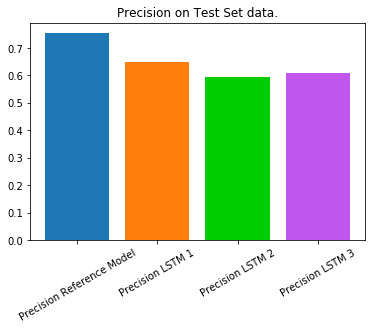

In [184]:
THIRD_MODEL_COLOR = "#c156ef"

colors = [REFERENCE_MODEL_COLOR, FIRST_MODEL_COLOR, SECOND_MODEL_COLOR, THIRD_MODEL_COLOR]

labels = ["Precision Reference Model", "Precision LSTM 1", "Precision LSTM 2", "Precision LSTM 3"]
data = [reference_model_test_set_precision, first_model_test_set_precision, second_model_test_set_precision, third_model_test_set_precision]
title = "Precision on Test Set data."

plot_barchart(labels, data, title, colors=colors)

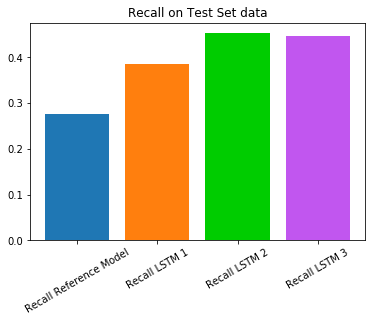

In [185]:
labels = ["Recall Reference Model", "Recall LSTM 1", "Recall LSTM 2", "Recall LSTM 3"]
data = [reference_model_test_set_recall, first_model_test_set_recall, second_model_test_set_recall, third_model_test_set_recall]
title = "Recall on Test Set data"

plot_barchart(labels, data, title, colors=colors)

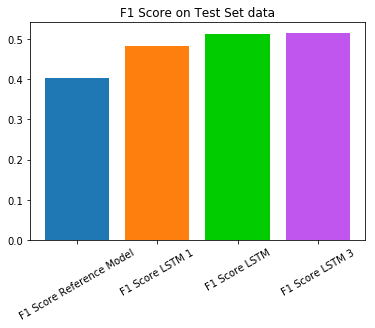

In [186]:
labels = ["F1 Score Reference Model", "F1 Score LSTM 1", "F1 Score LSTM", "F1 Score LSTM 3"]
data = [reference_model_test_set_f1, first_model_test_set_f1, second_model_test_set_f1, third_model_test_set_f1]
title = "F1 Score on Test Set data"

plot_barchart(labels, data, title, colors=colors)

## Step 7.3: Better representation of the words

The aim of thi setion is to understand if, given a better ditionary, made of stem instead of words we're going to have better performances of the models


In [187]:
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer

stemmer = PorterStemmer()

def preprocess_text(text, stemmer=None):
    words_filtered = []
    punctuation_remover = RegexpTokenizer(r'\w+')
    text = punctuation_remover.tokenize(text)
    for i, w in enumerate(text):     
        w = w.lower()
        if w not in stop_words and len(w) > 2 :
            if stemmer is not None:
                w = stemmer.stem(w)
            words_filtered.append(w)   
            
    return " ".join(words_filtered)   


In [188]:
articles["abstract_stems"] = articles.loc[:, "raw.abstract"].apply(preprocess_text, args=(stemmer,))

texts = [x.split(" ") for x in articles.loc[:, "abstract_stems"].tolist()]

In [189]:
gensim_model = gensim.models.Word2Vec(texts, size=VECTOR_DIMENSION, window=5, min_count=1, workers=15)

gensim_model.train(texts, total_examples=len(texts), epochs=10)

(18306366, 18977530)

In [190]:
len(gensim_model.wv.vocab)

50246

In [191]:
my_vocabulary_stem = {}
id_to_stem = {}

In [192]:
articles_top_tag.loc[:, 'abstract_stems' ] = articles_top_tag.loc[:, "raw.abstract"].apply(preprocess_text, args=(stemmer,))

articles_top_tag.loc[:, "abstract_stems"].apply(create_vocabulary, args=(my_vocabulary_stem, id_to_stem,))

articles_top_tag.loc[:, 'new_abstract_stem_ids'] = articles_top_tag.loc[:, "abstract_stems"].apply(get_article_words_ids, args=(my_vocabulary_stem,))

In [193]:
articles_top_tag.head(1)

,doc.id,title,citeulike.id,raw.title,raw.abstract,y_true,new_title,new_title_words_id,new_title_words_id_padded,new_abstract,new_abstract_words_id,new_abstract_words_id_padded,abstract_stems,new_abstract_stem_ids
0,1,the metabolic world of escherichia coli is not...,42.0,The metabolic world of Escherichia coli is not...,To elucidate the organizational and evolutiona...,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",metabolic world Escherichia coli small,"[1, 2, 3, 4, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...",elucidate organizational evolutionary principl...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",elucid organiz evolutionari principl metabol l...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [194]:
embedding_matrix_4 = build_embedding_matrix(my_vocabulary_stem, gensim_model.wv, VECTOR_DIMENSION)

In [195]:
print_vocabulary_stats(my_vocabulary_stem)

(30026, 0, 0.0)


In [196]:
MAX_ABSTRACT_STEM_LEN = len(max(articles_top_tag["new_abstract_stem_ids"].tolist(), key=len))

MIN_ABSTRACT_STEM_LEN = len(max(articles_top_tag["new_abstract_stem_ids"].tolist(), key=len))

AVG_ABSTRACT_STEM_LEN = [len(x) for x in articles_top_tag["new_abstract_stem_ids"].tolist()]
AVG_ABSTRACT_STEM_LEN = sum(AVG_ABSTRACT_STEM_LEN) / len(AVG_ABSTRACT_STEM_LEN)

print(MAX_ABSTRACT_STEM_LEN, MIN_ABSTRACT_STEM_LEN, AVG_ABSTRACT_STEM_LEN)

(5327, 5327, 113)


In [197]:
MAX_SENTENCE_LEN = 100

In [198]:
articles_top_tag.loc[:, "new_abstract_stems_id_padded" ] = articles_top_tag.loc[:, "new_abstract_stem_ids"].apply(pad_title, args=(MAX_SENTENCE_LEN,))

In [199]:
train_set, test_set = train_test_split(articles_top_tag, test_size=0.1, shuffle=True, random_state=1993)

# Second model train set input and y_true
fourth_model_train_set_input =  np.array(train_set.loc[:, "new_abstract_stems_id_padded"].tolist())
fourth_model_train_set_y_true =  np.array(train_set.loc[:, "y_true"].tolist())

# Second model test set input and y_true
fourth_model_test_set_input = np.array(test_set.loc[:, "new_abstract_stems_id_padded"].tolist())
fourth_model_test_set_y_true = np.array(test_set.loc[:, "y_true"].tolist())

fourth_model = get_model(my_vocabulary_stem, MAX_SENTENCE_LEN, VECTOR_DIMENSION, TOP_N_TAGS, embedding_matrix_4)

fourth_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 300)          9008100   
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                6020      
Total params: 9,735,320
Trainable params: 727,220
Non-trainable params: 9,008,100
_________________________________________________________________


In [200]:
fourth_model_weights_path = "fourth_model_weights.hdf5"
fourth_model_early_stop_by_f1 = EarlyStopByF1(OUTPUT_ACTIVATION_THRESHOLD, F1_PATIENCE, F1_BETA, fourth_model_weights_path)

fourth_model_metrics = [fourth_model_early_stop_by_f1]

In [202]:
fourth_model_history = fourth_model.fit(fourth_model_train_set_input, fourth_model_train_set_y_true, validation_split=0.1, batch_size=128, epochs=50, callbacks=fourth_model_metrics)

Train on 6792 samples, validate on 755 samples
Epoch 1/50
6792/6792 [==============================] - 46s 7ms/step - loss: 0.3271 - acc: 0.8817 - val_loss: 0.2763 - val_acc: 0.8966
val_f1: 0.188248 — val_precision: 0.535503 — val_recall 0.114196
Epoch 2/50
6792/6792 [==============================] - 46s 7ms/step - loss: 0.2633 - acc: 0.9003 - val_loss: 0.2475 - val_acc: 0.9060
val_f1: 0.343201 — val_precision: 0.642981 — val_recall 0.234069
Epoch 3/50
6792/6792 [==============================] - 46s 7ms/step - loss: 0.2388 - acc: 0.9076 - val_loss: 0.2327 - val_acc: 0.9123
val_f1: 0.441350 — val_precision: 0.666242 — val_recall 0.329968
Epoch 4/50
6792/6792 [==============================] - 47s 7ms/step - loss: 0.2238 - acc: 0.9128 - val_loss: 0.2269 - val_acc: 0.9152
val_f1: 0.465776 — val_precision: 0.688039 — val_recall 0.352050
Epoch 5/50
6792/6792 [==============================] - 46s 7ms/step - loss: 0.2136 - acc: 0.9174 - val_loss: 0.2212 - val_acc: 0.9170
val_f1: 0.495169 —

In [203]:
# Reload best weights for the model
fourth_model.load_weights(fourth_model_weights_path)

In [204]:
fourth_model_test_set_y_pred = get_output(fourth_model.predict(fourth_model_test_set_input), OUTPUT_ACTIVATION_THRESHOLD)
fourth_model_test_set_precision, fourth_model_test_set_recall, fourth_model_test_set_f1, support = precision_recall_fscore_support(fourth_model_test_set_y_true, fourth_model_test_set_y_pred, average="micro")

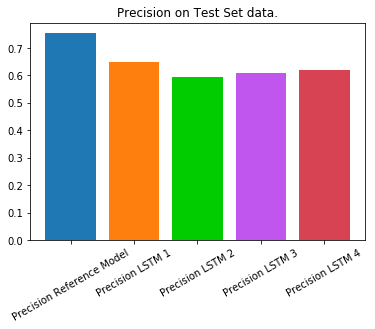

In [205]:
FOURTH_MODEL_COLOR = "#d84354"

colors = [REFERENCE_MODEL_COLOR, FIRST_MODEL_COLOR, SECOND_MODEL_COLOR, THIRD_MODEL_COLOR, FOURTH_MODEL_COLOR]

labels = ["Precision Reference Model", "Precision LSTM 1", "Precision LSTM 2", "Precision LSTM 3", "Precision LSTM 4"]
data = [reference_model_test_set_precision, first_model_test_set_precision, second_model_test_set_precision, third_model_test_set_precision, fourth_model_test_set_precision]
title = "Precision on Test Set data."
plot_barchart(labels, data, title, colors=colors)

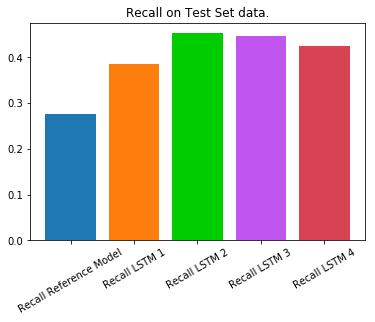

In [206]:
labels = ["Recall Reference Model", "Recall LSTM 1", "Recall LSTM 2", "Recall LSTM 3", "Recall LSTM 4"]
data = [reference_model_test_set_recall, first_model_test_set_recall, second_model_test_set_recall, third_model_test_set_recall, fourth_model_test_set_recall]
title = "Recall on Test Set data."
plot_barchart(labels, data, title, colors=colors)

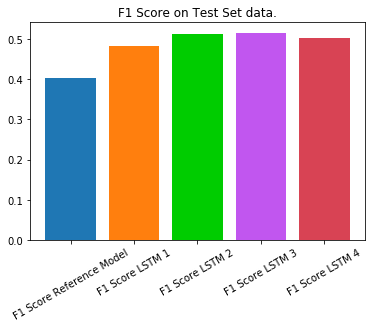

In [207]:
labels = ["F1 Score Reference Model", "F1 Score LSTM 1", "F1 Score LSTM 2", "F1 Score LSTM 3", "F1 Score LSTM 4"]
data = [reference_model_test_set_f1, first_model_test_set_f1, second_model_test_set_f1, third_model_test_set_f1, fourth_model_test_set_f1]
title = "F1 Score on Test Set data."
plot_barchart(labels, data, title, colors=colors)

## STEP 8: GRU

